Task 3: Model Deployment (Flask/Dashboard)
- Description
 : Deploy regression model as a simple web 
app/dashboard.
- Features
    - Build a Flask app or a Streamlit dashboard.
    - User inputs store/date → Predict sales.
    - Display actual vs. predicted sales charts.
    - Tech Stack
    : Python, Pandas, Scikit-learn, Flask/Streamlit.
- Learning Outcomes
: Learn how to deploy ML models for real
world use.
- DATA SET LINK 
https://www.kaggle.com/competitions/store-sales-time-series
forecasting


<table align="center">
  <td>
    <a href="https://colab.research.google.com/github/BUFONJOKER/internboot-task3/blob/master/Task3.ipynb" target="_parent">
      <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"
      style="height:80px; width:auto;"/>
    </a>
  </td>
</table>

This notebook is mostly the same as the Task 2 notebook.  
Key differences include:

- Fewer features used for faster model training and evaluation  
- Focus on preparing the model for deployment  
- Model saved using **pickle**  
- Preprocessor saved using **joblib** for later use in deployment


# 1-Import Libraries

In [94]:
# import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gdown
import xgboost
import lightgbm as lgb
import joblib
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (
    mean_absolute_error,
    root_mean_squared_error
)

# 2- Load Dataset

In [95]:
# this will take some time to run
# as files are large

# for large files to download
# we will use gdown library
# to download files from google drive

# we will use dataset which we
# cleaned and used for modeling
# in previous task

df_cleaned_modeling_file_id = "1WQ14D997naSLcvQGoMP3KsAjulIe9aSa"
df_cleaned_modeling_url = f"https://drive.google.com/uc?id={df_cleaned_modeling_file_id}"

gdown.download(df_cleaned_modeling_url, "df_cleaned_modeling.csv", quiet=False)
df_cleaned_modeling= pd.read_csv("df_cleaned_modeling.csv")

# for small files

stores_file_id = "1qeAyIRs9ZH2Bopy4Im_cwlvqPDAhGUVD"
stores_url = f"https://drive.google.com/uc?export=download&id={stores_file_id}"
df_stores = pd.read_csv(stores_url)


Downloading...
From (original): https://drive.google.com/uc?id=1WQ14D997naSLcvQGoMP3KsAjulIe9aSa
From (redirected): https://drive.google.com/uc?id=1WQ14D997naSLcvQGoMP3KsAjulIe9aSa&confirm=t&uuid=68dc794b-c73d-4f48-8baa-bd8a5dc9b330
To: /content/df_cleaned_modeling.csv
100%|██████████| 162M/162M [00:01<00:00, 147MB/s]


# 3- Exploratory Data Analysis (EDA)

In [96]:
df_cleaned_modeling.head()

,id,date,store_nbr,family,sales,onpromotion,isHoliday,day_of_week,month,year
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,1.0,1,1,2013
1,1,2013-01-01,1,BABY CARE,0.0,0,1.0,1,1,2013
2,2,2013-01-01,1,BEAUTY,0.0,0,1.0,1,1,2013
3,3,2013-01-01,1,BEVERAGES,0.0,0,1.0,1,1,2013
4,4,2013-01-01,1,BOOKS,0.0,0,1.0,1,1,2013


In [97]:
df_stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [98]:
df = pd.merge(df_cleaned_modeling,df_stores,on='store_nbr',how='left')

In [99]:
df.head()

,id,date,store_nbr,family,sales,onpromotion,isHoliday,day_of_week,month,year,city,state,type,cluster
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,1.0,1,1,2013,Quito,Pichincha,D,13
1,1,2013-01-01,1,BABY CARE,0.0,0,1.0,1,1,2013,Quito,Pichincha,D,13
2,2,2013-01-01,1,BEAUTY,0.0,0,1.0,1,1,2013,Quito,Pichincha,D,13
3,3,2013-01-01,1,BEVERAGES,0.0,0,1.0,1,1,2013,Quito,Pichincha,D,13
4,4,2013-01-01,1,BOOKS,0.0,0,1.0,1,1,2013,Quito,Pichincha,D,13


In [100]:
df.shape

(3013362, 14)

In [101]:
df.isnull().sum()

,0
id,0
date,0
store_nbr,0
family,0
sales,0
onpromotion,0
isHoliday,0
day_of_week,0
month,0
year,0


In [102]:
df.duplicated().sum()

np.int64(0)

In [103]:
df.columns

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion',
       'isHoliday', 'day_of_week', 'month', 'year', 'city', 'state', 'type',
       'cluster'],
      dtype='object')

In [104]:
df.dtypes

,0
id,int64
date,object
store_nbr,int64
family,object
sales,float64
onpromotion,int64
isHoliday,float64
day_of_week,int64
month,int64
year,int64


In [105]:
df['type'].value_counts()

,count
type,
D,1004454
C,837045
A,502227
B,446424
E,223212


In [106]:
df['cluster'].value_counts()

,count
cluster,
3,390621
10,334818
6,334818
15,279015
13,223212
14,223212
4,167409
8,167409
1,167409


In [107]:
df['family'].value_counts()

,count
family,
AUTOMOTIVE,91314
BABY CARE,91314
BEAUTY,91314
BEVERAGES,91314
BOOKS,91314
BREAD/BAKERY,91314
CELEBRATION,91314
CLEANING,91314
DAIRY,91314


In [108]:
df['city'].unique()

array(['Quito', 'Cayambe', 'Latacunga', 'Riobamba', 'Ibarra',
       'Santo Domingo', 'Guaranda', 'Puyo', 'Ambato', 'Guayaquil',
       'Salinas', 'Daule', 'Babahoyo', 'Quevedo', 'Playas', 'Libertad',
       'Cuenca', 'Loja', 'Machala', 'Esmeraldas', 'Manta', 'El Carmen'],
      dtype=object)

In [109]:
df['state'].unique()

array(['Pichincha', 'Cotopaxi', 'Chimborazo', 'Imbabura',
       'Santo Domingo de los Tsachilas', 'Bolivar', 'Pastaza',
       'Tungurahua', 'Guayas', 'Santa Elena', 'Los Rios', 'Azuay', 'Loja',
       'El Oro', 'Esmeraldas', 'Manabi'], dtype=object)

<Axes: >

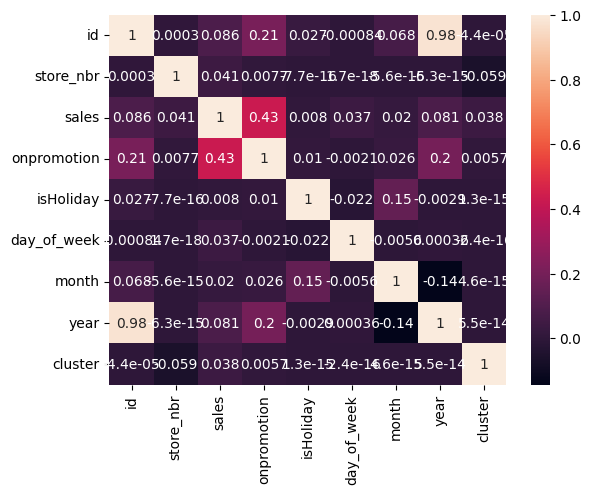

In [110]:
sns.heatmap(df.corr(numeric_only=True),annot=True)

# 4- Model Building

In [111]:
df.columns

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion',
       'isHoliday', 'day_of_week', 'month', 'year', 'city', 'state', 'type',
       'cluster'],
      dtype='object')

In [112]:
features = ['store_nbr','isHoliday','month']
target = ['sales']

In [113]:
df.dtypes

,0
id,int64
date,object
store_nbr,int64
family,object
sales,float64
onpromotion,int64
isHoliday,float64
day_of_week,int64
month,int64
year,int64


In [114]:
X = df[features]
y = df['sales']

In [115]:
X_train, X_test, y_train, y_test = train_test_split(
    X,y,test_size=0.2,random_state=42
)

In [116]:
scaler=StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [117]:
X_train.shape

(2410689, 3)

In [118]:
X_train

,store_nbr,isHoliday,month
2918454,46,1.0,6
785705,54,0.0,3
2343365,10,1.0,8
1398932,10,0.0,2
2134880,10,1.0,4
...,...,...,...
1692743,54,0.0,8
2356330,23,1.0,8
2229084,53,0.0,6
2768307,33,0.0,3


In [119]:
X_train_scaled

array([[ 1.18705202,  2.7397815 , -0.06078013],
       [ 1.70042169, -0.36499261, -0.94787825],
       [-1.12311152,  2.7397815 ,  0.53061861],
       ...,
       [ 1.63625048, -0.36499261, -0.06078013],
       [ 0.3528263 , -0.36499261, -0.94787825],
       [-0.2888858 ,  2.7397815 , -0.35647951]])

In [120]:
models = {
    'LinearRegression':LinearRegression(),
    'DecisionTreeRegressor':DecisionTreeRegressor(),
    'RandomForestRegressor':RandomForestRegressor(),
    'LGBMRegressor':lgb.LGBMRegressor(),
    "XGBRegressor":xgboost.XGBRegressor(),
}
mae = {}
rmse = {}

In [121]:
for name,model in models.items():
    model.fit(X_train_scaled,y_train)
    y_pred = model.predict(X_test_scaled)
    mae[name] = mean_absolute_error(y_test,y_pred)
    rmse[name] = root_mean_squared_error(y_test,y_pred)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.112112 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 71
[LightGBM] [Info] Number of data points in the train set: 2410689, number of used features: 3
[LightGBM] [Info] Start training from score 358.445723


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [122]:
mae

{'LinearRegression': 512.372465437848,
 'DecisionTreeRegressor': 490.9049719888257,
 'RandomForestRegressor': 490.9126614863829,
 'LGBMRegressor': 490.9365659048298,
 'XGBRegressor': 490.852732327988}

In [123]:
rmse

{'LinearRegression': 1096.414262646626,
 'DecisionTreeRegressor': 1071.6056853628922,
 'RandomForestRegressor': 1071.61030843885,
 'LGBMRegressor': 1071.3695017721825,
 'XGBRegressor': 1071.487670038439}

In [124]:
joblib.dump(scaler,'scaler.pkl')

['scaler.pkl']

In [125]:
for model_name,model in models.items():
    joblib.dump(model,f"{model_name}.pkl")